# 🤖 Detecção de Comportamentos Anômalos com IA (Isolation Forest)
Este notebook usa aprendizado de máquina para detectar sessões suspeitas com base em métricas dos logs.

In [1]:
!pip install plotly pandas openpyxl

📁 Arquivo Excel gerado com sucesso.


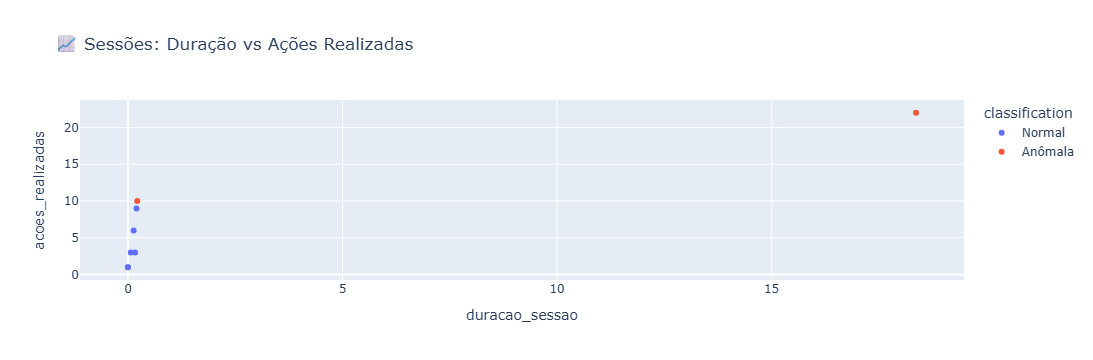

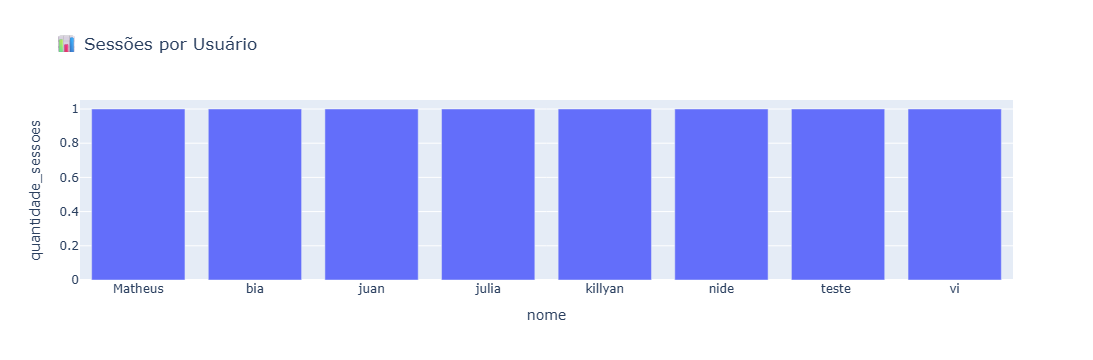

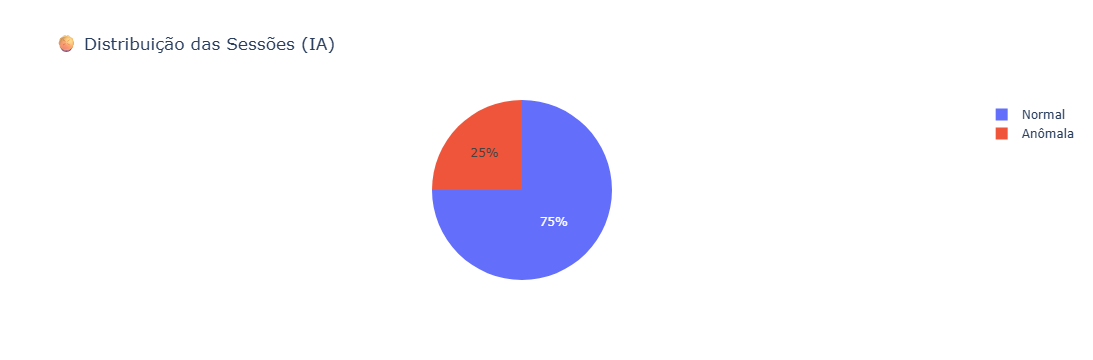

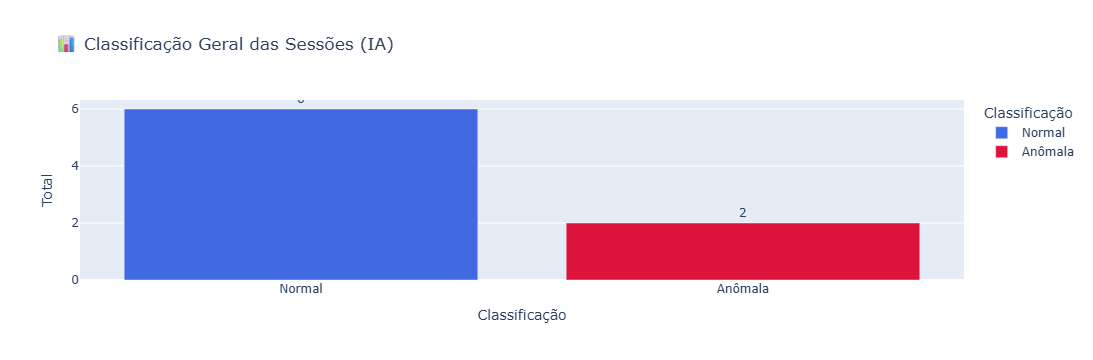


✅ Pipeline finalizada com sucesso!

📊 Classificação das Sessões:
classification
Normal     6
Anômala    2
Name: count, dtype: int64


In [2]:
import sqlite3
import pandas as pd
import plotly.express as px
from sklearn.ensemble import IsolationForest
import os

# 📥 Carregar e processar sessões a partir de todos os logs
def carregar_dados_sessoes():
    db_path = "../database.db"  # Corrigido para o caminho atual
    if not os.path.exists(db_path):
        raise FileNotFoundError("Banco de dados não encontrado.")

    conn = sqlite3.connect(db_path)
    query = """
        SELECT u.id AS usuario_id, u.nome, u.email, l.acao_usuario AS acao, l.data_hora
        FROM logs l
        JOIN usuarios u ON u.id = l.usuario_id
    """
    df = pd.read_sql_query(query, conn)
    conn.close()

    df['data_hora'] = pd.to_datetime(df['data_hora'])
    df['data'] = df['data_hora'].dt.strftime('%d/%m/%Y')

    df_sessoes = df.groupby(
        ['usuario_id', 'nome', 'email', 'data'],
        dropna=False
    ).agg(
        duracao_sessao=('data_hora', lambda x: (x.max() - x.min()).total_seconds() / 60 if len(x) > 1 else 0),
        acoes_realizadas=('acao', 'count')
    ).reset_index()

    return df_sessoes

# 🤖 Aplicar IA com Isolation Forest
def aplicar_classificacao_ia(df_sessoes):
    modelo = IsolationForest(contamination=0.2, random_state=42)
    X = df_sessoes[['duracao_sessao', 'acoes_realizadas']]
    modelo.fit(X)
    predicoes = modelo.predict(X)
    df_sessoes['classification'] = ['Anômala' if p == -1 else 'Normal' for p in predicoes]
    return df_sessoes

# 📊 Gráfico geral de classificação
def gerar_grafico_geral_classificacao(df_sessoes):
    df_class = df_sessoes['classification'].value_counts().reset_index()
    df_class.columns = ['Classificação', 'Total']
    cores = {'Normal': 'royalblue', 'Anômala': 'crimson'}
    fig = px.bar(df_class, x='Classificação', y='Total', text='Total',
                 color='Classificação', color_discrete_map=cores,
                 title='📊 Classificação Geral das Sessões (IA)')
    fig.update_traces(textposition='outside')
    fig.show()

# 📈 Exibir gráficos
def exibir_graficos(df):
    fig1 = px.scatter(df, x='duracao_sessao', y='acoes_realizadas',
                      color='classification', hover_data=['usuario_id', 'nome', 'email', 'data'],
                      title='📈 Sessões: Duração vs Ações Realizadas')
    fig1.show()

    df_usuarios = df.groupby('nome').size().reset_index(name='quantidade_sessoes')
    fig2 = px.bar(df_usuarios, x='nome', y='quantidade_sessoes',
                  title='📊 Sessões por Usuário')
    fig2.show()

    df_class = df['classification'].value_counts().reset_index()
    df_class.columns = ['Classificação', 'Quantidade']
    fig3 = px.pie(df_class, names='Classificação', values='Quantidade',
                  title='🥧 Distribuição das Sessões (IA)')
    fig3.show()

    gerar_grafico_geral_classificacao(df)

# 🚀 Executar pipeline
def executar_pipeline():
    df = carregar_dados_sessoes()
    df = aplicar_classificacao_ia(df)

    df.to_csv("sessoes_ia_completas.csv", index=False, encoding="utf-8-sig")
    try:
        df.to_excel("sessoes_ia_completas.xlsx", index=False)
        print("📁 Arquivo Excel gerado com sucesso.")
    except Exception as e:
        print(f"⚠️ Erro ao salvar Excel: {e}")

    exibir_graficos(df)

    print("\n✅ Pipeline finalizada com sucesso!")
    print("\n📊 Classificação das Sessões:")
    print(df['classification'].value_counts())

# ▶️ Executar
executar_pipeline()
